In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import warnings

In [2]:
df_cleaned = pd.read_csv("dataframe_final.csv", sep=",")
df_cleaned.describe()

,Any,Mes,Dia,Tram_Horari,Codi_Postal,Valor,temperature_2m,apparent_temperature,wind_speed_10m,sunshine_duration,direct_radiation,Dia_Setmana,Tasa interanual del IPI,dew_point_2m
count,348030.000000,348030.000000,348030.000000,348030.000000,348030.000000,348030.000000,348030.000000,348030.000000,348030.000000,348030.000000,348030.000000,348030.000000,348030.000000,348030.000000
mean,2021.361371,6.419093,15.821625,2.499787,8021.482174,101077.228582,16.493652,15.894976,9.636141,8927.526240,132.840098,4.000132,0.068119,11.304799
std,1.646060,3.378734,8.818198,1.118508,12.118382,56626.111563,6.916633,8.696049,5.371176,9751.004453,168.621376,2.000879,10.523790,6.487438
min,2019.000000,1.000000,1.000000,1.000000,8001.000000,99.000000,-1.472500,-5.783517,0.000000,0.000000,0.000000,1.000000,-34.250000,-13.322500
25%,2020.000000,4.000000,8.000000,1.000000,8011.000000,57872.250000,11.177500,9.136863,5.804825,0.000000,0.000000,2.000000,-3.700000,6.627500
50%,2021.000000,6.000000,16.000000,2.000000,8021.000000,90795.638279,16.377500,15.410418,8.373386,0.000000,9.166667,4.000000,0.380000,11.477500
75%,2023.000000,9.000000,23.000000,4.000000,8032.000000,132299.000000,21.927502,23.278515,12.558790,20244.717000,252.333330,6.000000,2.500000,16.777500
max,2024.000000,12.000000,31.000000,4.000000,8042.000000,350933.000000,36.577500,38.466156,45.001440,21600.000000,557.833300,7.000000,54.460000,25.127500


In [3]:
X = df_cleaned.drop(columns=['Tasa interanual del IPI', 'Valor'])

y = df_cleaned['Valor']  # Target variable

### RandomForestRegressor

In [4]:
model = RandomForestRegressor()
model.fit(X, y)
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Variable': X.columns, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                Variable  Importance
4            Codi_Postal    0.682104
3            Tram_Horari    0.101649
0                    Any    0.071121
1                    Mes    0.034992
12           Dia_Setmana    0.030138
6   apparent_temperature    0.025044
5         temperature_2m    0.018572
2                    Dia    0.007359
14          dew_point_2m    0.006594
11      direct_radiation    0.006163
13                Festiu    0.005766
8         wind_speed_10m    0.005346
10     sunshine_duration    0.002763
9                 is_day    0.001884
7                   rain    0.000506


In [5]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate MAE and MSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
print('Mean Absolute Percentage Error (MAPE): ', mae * 100 / (y_test.max() - y_test.min()))

Mean Absolute Error (MAE): 5512.566651577449
Mean Squared Error (MSE): 114431613.28055021
R² Score: 0.96446250895154
Mean Absolute Percentage Error (MAPE):  1.5755547319166943


### GridSearchCV

In [4]:
# Random Forest model definition
rf_model = RandomForestRegressor(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reduce dataset size
from sklearn.utils import resample

# Subsample 30% of training data
X_train_small, y_train_small = resample(X_train, y_train, replace=False, n_samples=int(0.3 * len(X_train)), random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [300],
    'max_depth': [None, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.0005]
}

# Hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=1, verbose=2)
grid_search.fit(X_train_small, y_train_small)

# Best hyperparameters found
print("Best hyperparameters found:", grid_search.best_params_)

# Train model with best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_small, y_train_small)

# Predictions
y_pred = best_model.predict(X_test)

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
print('Mean Absolute Error (MAE) in %: ', mae * 100 / (y_test.max() - y_test.min()))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END ccp_alpha=0.0005, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.6min
[CV] END ccp_alpha=0.0005, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.7min
[CV] END ccp_alpha=0.0005, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.6min
[CV] END ccp_alpha=0.0005, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 1.2min
[CV] END ccp_alpha=0.0005, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 1.2min
[CV] END ccp_alpha=0.0005, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 1.1min
[CV] END ccp_alpha=0.0005, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_spli

#### **Modification of some parameters**


Mean Absolute Error (MAE) in %:  1.576261978123618
R² test: 0.9645


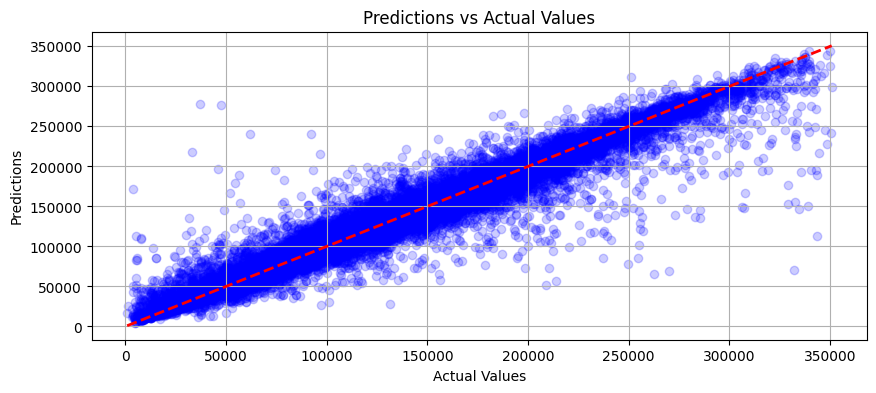

In [8]:
from sklearn.preprocessing import StandardScaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize scaler
scaler = StandardScaler()

# Fit and transform X_train, only transform X_test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ran_for_model = RandomForestRegressor(ccp_alpha=0.0005, max_depth=None, max_features=None,min_samples_leaf=2, min_samples_split=2, n_estimators=600)

# Train model
ran_for_model.fit(X_train, y_train)

# Predictions
y_pred = ran_for_model.predict(X_test)

# Performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE) in %: ', mae * 100 / (y_test.max() - y_test.min()))
print(f"R² test: {r2:.4f}")

"""Plot prediction results vs actual values"""

plt.figure(figsize=(10, 4))
plt.scatter(y_test, y_pred, alpha=0.2, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')  # Ideal line
plt.title("Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.grid()
plt.show()

### Residual plot

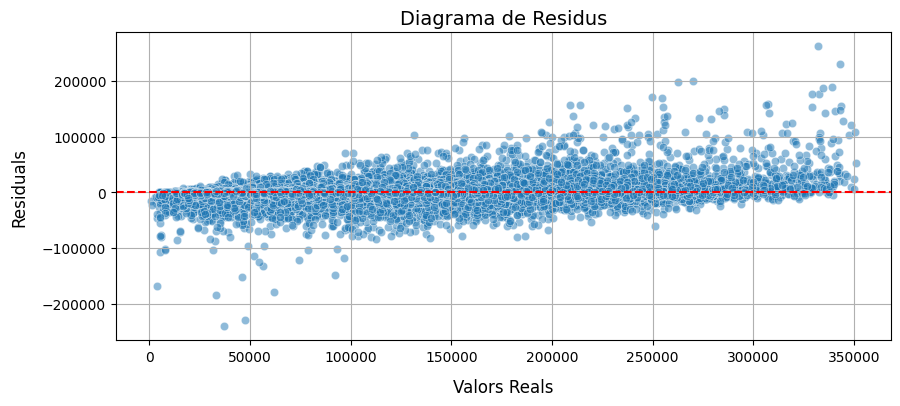

In [19]:
import seaborn as sns

residuals = y_test - y_pred
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_test, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valors Reals", fontsize=12, labelpad=10)
plt.ylabel("Residuals", fontsize=12, labelpad=10)
plt.title("Diagrama de Residus", fontsize=14)
plt.grid(True)
plt.show()

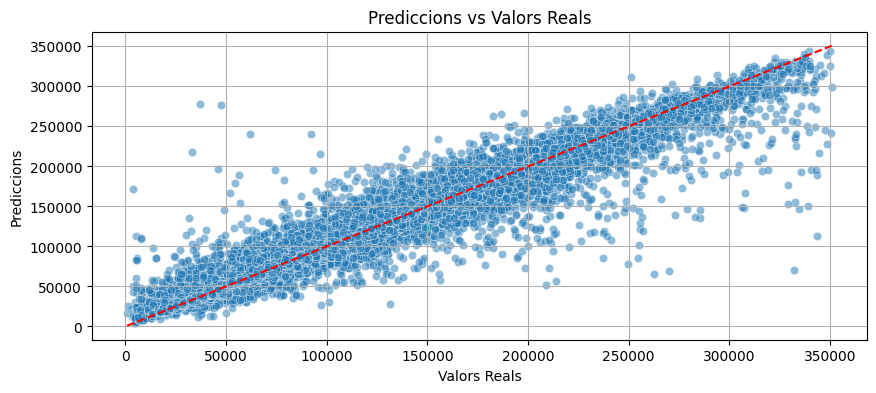

In [21]:
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valors Reals")
plt.ylabel("Prediccions")
plt.title("Prediccions vs Valors Reals")
plt.grid(True)
plt.show()

#### Quantifying Associated Uncertainty

       Predicció    Incertesa
0   33166.418849   713.231758
1  104858.900122  2651.220554
2  120116.501251  8182.604181
3   91153.969155  2329.171130
4   58292.567473  2191.631000
Incertesa mediana:  6553.611834735508 / Relativa al total:  1.8730973773184334 %
Incertesa mitjana:  8630.441210251896 / Relativa al total:  2.4666790166519177 %


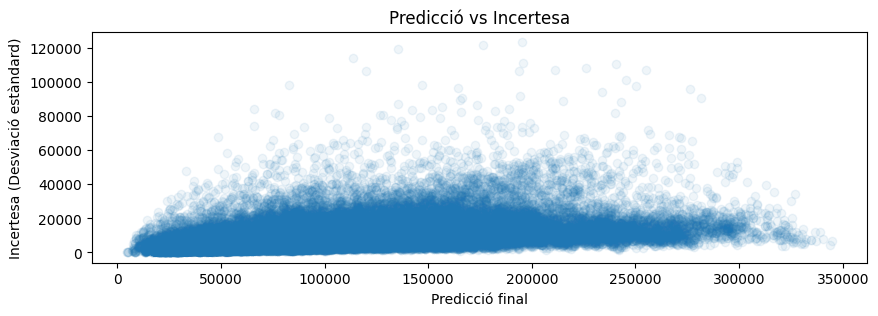

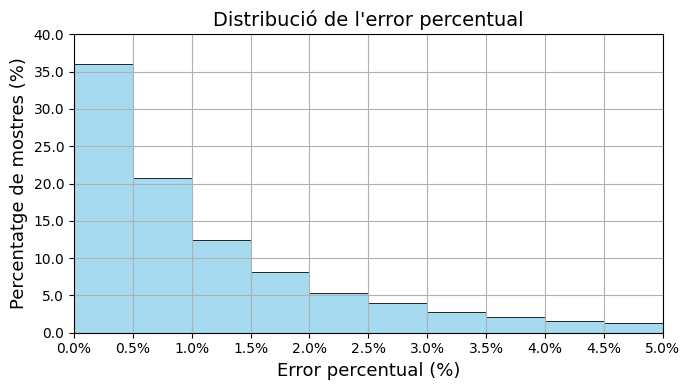

In [22]:
import warnings
warnings.filterwarnings('ignore')  # X té noms de característiques, però el DecisionTreeRegressor es va ajustar sense noms

# Obtenim les prediccions de tots els arbres
all_tree_preds = np.array([tree.predict(X_test) for tree in ran_for_model.estimators_])

# Mitjana de les prediccions (predicció final)
final_prediction = np.mean(all_tree_preds, axis=0)

# Incertesa (desviació estàndard de les prediccions)
prediction_uncertainty = np.std(all_tree_preds, axis=0)

# Creem un DataFrame amb les prediccions i la incertesa
df_predictions = pd.DataFrame({
    'Predicció': final_prediction,
    'Incertesa': prediction_uncertainty
})

# Mostrem les primeres files
print(df_predictions.head())

# Estadístiques de la incertesa
print('Incertesa mediana: ', df_predictions['Incertesa'].median(), '/',
      'Relativa al total: ', (df_predictions['Incertesa'].median() / (y_test.max() - y_test.min())) * 100, '%')
print('Incertesa mitjana: ', df_predictions['Incertesa'].mean(), '/',
      'Relativa al total: ', (df_predictions['Incertesa'].mean() / (y_test.max() - y_test.min())) * 100, '%')

# Gràfic de predicció vs incertesa
plt.figure(figsize=(10, 3))
plt.scatter(final_prediction, prediction_uncertainty, alpha=0.07)
plt.title("Predicció vs Incertesa")
plt.xlabel("Predicció final")
plt.ylabel("Incertesa (Desviació estàndard)")
plt.show()

import seaborn as sns

def avalua_model_mc(y_test, y_pred):
    # Calculem l'error percentual
    Min = y_test.min()
    Max = y_test.max()
    Rang = Max - Min

    errors_percentual = (abs(y_test - y_pred) / abs(Rang)) * 100

    # Limitem els errors
    errors_percentual = np.clip(errors_percentual, 0, 30)

    # Creem la figura
    fig, ax = plt.subplots(figsize=(7, 4))

    # Histograma amb distribució de densitat
    sns.histplot(errors_percentual, kde=False, stat="percent", bins=60, ax=ax,
                 color="skyblue", edgecolor="black")

    # Estètica del gràfic
    ax.set_title("Distribució de l'error percentual", fontsize=14)
    ax.set_xlabel("Error percentual (%)", fontsize=13)
    ax.set_ylabel("Percentatge de mostres (%)", fontsize=13)

    ax.set_xlim(left=0, right=5)
    ax.set_ylim(bottom=0)

    ax.set_xticks(np.arange(0, 5.1, 0.5))
    ax.set_xticklabels([f'{i}%' for i in np.arange(0, 5.1, 0.5)])

    ax.set_yticks(np.arange(0, 41, 5))
    ax.set_yticklabels([f'{i:.1f}' for i in np.arange(0, 41, 5)])
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# Avaluem el model amb gràfic d'errors
avalua_model_mc(y_test, y_pred)
